In [73]:
import pandas as pd
import numpy as np
import os
from skimage import io, transform ,feature
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import cv2

In [74]:
def apply_hog_to_color_image(image_path, resize_dim=(160, 160), pixels_per_cell=(8, 8), cells_per_block=(4, 4), orientations=9):
    try:
        img = io.imread(image_path)
        img_resized = transform.resize(img, resize_dim)  # Resize for uniformity
        
        # Specify the channel axis
        channel_axis = -1 if img_resized.ndim == 3 else None

        fd = hog(img_resized, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                 cells_per_block=cells_per_block, feature_vector=True, channel_axis=channel_axis)
        return fd
    except IOError:
        return None


In [75]:
from skimage.color import rgb2gray

def apply_canny_to_color_image(image, sigma=1):
    # Convert to grayscale as Canny is typically applied to grayscale images
    gray_image = rgb2gray(image)
    edges = feature.canny(gray_image, sigma=sigma)
    return edges.flatten()

def augment_data(features):
    # Define your data augmentation logic here
    # For example, you can add random noise, flip images, etc.
    # Ensure that augmentation is applicable to your feature set
    augmented_features = []
    for feature in features:
        # Example: Add random noise
        noise = np.random.normal(0, 5, feature.shape)
        feature_noisy = feature + noise
        augmented_features.append(feature_noisy)

        # Add more augmentation methods as needed
    return np.array(augmented_features)


In [76]:
#not sure but i guess the next one was used and this one was getting some error
train_csv_path = 'Human Action Recognition/Training_set.csv'
train_data = pd.read_csv(train_csv_path)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_image_directory = 'Human Action Recognition/train'
processed_features = []
labels = []

for dataset in [train_data, val_data]:
    for filename in tqdm(dataset['filename']):
        image_path = os.path.join(train_image_directory, filename)
        img = io.imread(image_path)
        
        # Resize image for consistent feature size (both for HOG and Canny)
        img_resized = transform.resize(img, (160, 160))  # Adjust size as needed

        # Apply HOG to resized color image
        hog_features = apply_hog_to_color_image(image_path, resize_dim=(160, 160))

        # Apply Canny to resized grayscale image
        canny_features = apply_canny_to_color_image(img_resized)

        # Ensure both feature vectors are of the same length
        if len(hog_features) == len(canny_features):
            combined_features = np.concatenate((hog_features, canny_features))
            processed_features.append(combined_features)
            labels.append(dataset['label'])

# Check if all feature vectors have the same length
if all(len(feat) == len(processed_features[0]) for feat in processed_features):
    print("All feature vectors are uniform in length.")
else:
    raise ValueError("Feature vectors are not uniform in length.")

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


# Convert list to array
processed_features = np.array(processed_features)


100%|██████████| 2520/2520 [00:52<00:00, 47.59it/s]

All feature vectors are uniform in length.


In [82]:
import pandas as pd
from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Define your apply_hog_to_color_image and apply_canny_to_color_image functions here

train_csv_path = 'Human Action Recognition/Training_set.csv'
train_data = pd.read_csv(train_csv_path)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

train_image_directory = 'Human Action Recognition/train'
processed_features = []
labels = []

for dataset in [train_data, val_data]:
    for index, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
        filename = row['filename']
        label = row['label']
        image_path = os.path.join(train_image_directory, filename)
        img = io.imread(image_path)
        
        if img.size == 0:
            print(f"Failed to load image: {filename}")
            continue  # Skip this iteration

        img_resized = transform.resize(img, (160, 160))  # Adjust size as needed

        hog_features = apply_hog_to_color_image(image_path, resize_dim=(160, 160))
        canny_features = apply_canny_to_color_image(img_resized)

        if img.size == 0 or hog_features is None or canny_features is None:
            continue

        combined_features = np.concatenate((hog_features, canny_features))
        processed_features.append(combined_features)
        labels.append(label)

# Check if any features were extracted
if not processed_features:
    raise ValueError("No features were extracted.")

# Check if all feature vectors have the same length
if not all(len(feat) == len(processed_features[0]) for feat in processed_features):
    raise ValueError("Feature vectors are not uniform in length.")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

processed_features = np.array(processed_features)
print("Feature extraction successful. Processed features shape:", processed_features.shape)


100%|██████████| 2520/2520 [02:19<00:00, 18.06it/s]


Feature extraction successful. Processed features shape: (12600, 67216)


In [78]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score


In [79]:
print(processed_features.shape)

(0,)


In [84]:
scaler = StandardScaler()

# Fit and transform the features
processed_features = scaler.fit_transform(processed_features)

In [85]:
from sklearn.decomposition import PCA

from sklearn.decomposition import PCA

# Ensure processed_images is a numpy array
# processed_images = np.array(all_features_standardized)

# Initialize PCA with 100 components
pca = PCA(n_components=200)

# Fit and transform the processed images with PCA
all_features_standardized = pca.fit_transform(processed_features)


In [94]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_features_standardized, labels, test_size=0.3, random_state=42)

# Train SVM model
svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate on validation set
predicted_val_labels = svm_model.predict(X_val)
accuracy = accuracy_score(y_val, predicted_val_labels)
print(f"Accuracy on validation set: {accuracy:.4f}")


Accuracy on validation set: 0.3542


In [95]:
predicted_val_labels = svm_model.predict(X_train)
accuracy = accuracy_score(y_train, predicted_val_labels)
print(f"Accuracy on validation set: {accuracy:.4f}")

Accuracy on validation set: 0.7951


In [96]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score


In [97]:
X_train, X_val, y_train, y_val = train_test_split(all_features_standardized, labels, test_size=0.3, random_state=42)
ovr_classifier = OneVsRestClassifier(SVC(kernel='rbf', gamma='scale', probability=False, random_state=42))
ovr_classifier.fit(X_train, y_train)
predicted_val_labels = ovr_classifier.predict(X_val)
accuracy = accuracy_score(y_val, predicted_val_labels)
print(f"Accuracy on validation set (OvR): {accuracy:.4f}")

Accuracy on validation set (OvR): 0.3757


In [103]:
import matplotlib.pyplot as plt

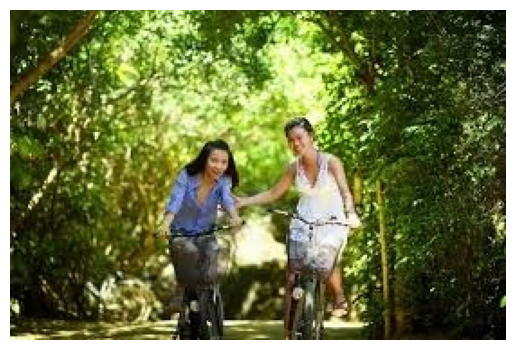

(1, 200)
ovr ['running']
single ['cycling']
Prediction: 1


In [139]:
def predict_single_image(image_path, hog_model, canny_model, scaler, pca, svm_model):
    try:
        # Read and preprocess the image
        img = io.imread(image_path)
        plt.imshow(img)
        plt.axis('off')  # Turn off axis numbers and labels
        plt.show()
        img_resized = transform.resize(img, (160, 160))  # Resize to match training data

        # Extract features
        hog_features = hog_model(image_path)  # Replace with actual HOG feature extraction
        canny_features = canny_model(img_resized)  # Replace with actual Canny feature extraction

        # Combine HOG and Canny features
        combined_features = np.concatenate((hog_features, canny_features))

        # Standardize and PCA transform
        combined_features = combined_features.reshape(1, -1)  # Reshape for single sample
        standardized_features = scaler.transform(combined_features)
        pca_features = pca.transform(standardized_features)
        print(pca_features.shape)

        # Predict using the trained SVM model
        prediction1 = ovr_classifier.predict(pca_features)
        prediction2 = svm_model.predict(pca_features)
        print("ovr",prediction1)
        print("single",prediction2)
        return 1

    except Exception as e:
        print(f"Error in processing the image: {e}")
        return None

# Example usage
image_path = 'Human Action Recognition\\test\Image_1413.jpg'
prediction = predict_single_image(image_path, apply_hog_to_color_image, apply_canny_to_color_image, scaler, pca, svm_model)
print("Prediction:", prediction)


In [141]:
# Not used in Final Prediction
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Assuming your data is in processed_train_images and encoded_labels
X_train, X_val, y_train, y_val = train_test_split(all_features_standardized, encoded_labels, test_size=0.3, random_state=42)

# Initialize the base SVM classifier
base_svm = SVC(kernel='rbf', gamma='scale', probability=True, random_state=42)

# Initialize the Bagging classifier with SVM
bagging_svm = BaggingClassifier(base_estimator=base_svm, n_estimators=10, random_state=42)

# Train the Bagging classifier
bagging_svm.fit(X_train, y_train)

# Evaluate the model
bagging_accuracy = bagging_svm.score(X_val, y_val)
print("Bagging Accuracy:", bagging_accuracy)


c:\Users\ecesoclab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging Accuracy: 0.35529100529100527


In [142]:
# Not used in Final Prediction

from sklearn.ensemble import AdaBoostClassifier

# Initialize the base SVM classifier
base_svm = SVC(kernel='rbf', gamma='scale', probability=True, random_state=42)

# Initialize AdaBoost with SVM (note: this might not be effective)
adaboost_svm = AdaBoostClassifier(base_estimator=base_svm, n_estimators=10, random_state=42)

# Train AdaBoost
adaboost_svm.fit(X_train, y_train)

# Evaluate the model
adaboost_accuracy = adaboost_svm.score(X_val, y_val)
print("AdaBoost with SVM Accuracy:", adaboost_accuracy)


c:\Users\ecesoclab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost with SVM Accuracy: 0.3074074074074074


In [143]:
# Not used in Final Prediction

bagging_accuracy = bagging_svm.score(X_train, y_train)
print("Bagging Accuracy:", bagging_accuracy)

Bagging Accuracy: 0.845578231292517


In [144]:
# Not used in Final Prediction

from sklearn.preprocessing import StandardScaler
import cv2
from skimage.segmentation import quickshift

In [145]:
# Not used in Final Prediction

def apply_mean_shift_segmentation(img):
    segmented_img = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)

    # Optional: Flatten the segmented image for feature vector
    flat_features = segmented_img.flatten()
    return flat_features

In [ ]:
# Not used in Final Prediction

import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os

train_csv_path = 'C:/Aayush/IIITD/Assignments/ML Assignments/ML Project/HAR Dataset/Training_set.csv'
train_data = pd.read_csv(train_csv_path)

train_image_directory = 'C:/Aayush/IIITD/Assignments/ML Assignments/ML Project/HAR Dataset/train'
processed_features = []
labels = []

def remove_background_threshold(image, threshold=100):
    # Apply thresholding
    _, thresh_img = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return thresh_img

ct = 0
for index, row in train_data.iterrows():
    filename = row['filename']
    label = row['label']
    image_path = os.path.join(train_image_directory, filename)

    img = cv2.imread(image_path, 0)  # Read image in grayscale
    img = cv2.resize(img, (160, 160))

    # Background removal
    processed_img = remove_background_threshold(img)
    # print(processed_img.shape)
    # break

    # Flatten the image and append to processed_features
    processed_features.append(processed_img.flatten())

    labels.append(label)
    print(ct, "Done!!!")
    ct += 1

# Check feature uniformity
if all(len(feat) == len(processed_features[0]) for feat in processed_features):
    print("All feature vectors are uniform in length.")
else:
    raise ValueError("Feature vectors are not uniform in length.")

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert list to array
processed_features = np.array(processed_features)


In [ ]:
# Not used in Final Prediction

hog_features = [sublist[:104976] for sublist in processed_features]

canny_features = [sublist[104976:162576] for sublist in processed_features]

mean_shift = [sublist[162576:] for sublist in processed_features]

# canny_features = processed_features[:, 41616:67216]
# mean_shift = processed_features[:, 67216:]

In [ ]:
# Not used in Final Prediction

hog_features = np.array(hog_features)
canny_features = np.array(canny_features)
mean_shift = np.array(mean_shift)
print(hog_features.shape)
print(canny_features.shape)
print(mean_shift.shape)

In [ ]:
# Not used in Final Prediction

L = ["C:/Aayush/IIITD/Assignments/ML Assignments/ML Project/HAR Dataset/test/Image_1.jpg"]

X_test = []

for path in L:
    image_path = path
    img = io.imread(image_path)
    
    # Resize image for consistent feature size (both for HOG and Canny)
    img_resized = transform.resize(img, (160, 160))  # Adjust size as needed

    # Apply HOG to resized color image
    hog_features = apply_hog_to_color_image(image_path, resize_dim=(160, 160))

    # Apply Canny to resized grayscale image
    canny_features = apply_canny_to_color_image(img_resized)
    
    mean_shift = apply_mean_shift_segmentation(img_resized)

    # Ensure both feature vectors are of the same length
    # if len(hog_features) == len(canny_features):
    combined_features = np.concatenate((hog_features, canny_features, mean_shift))
    combined_features = combined_features.reshape(1, -1)
    
    scaler = StandardScaler()

    # Fit and transform the features
    all_features_standardized_test = scaler.fit_transform(combined_features)
    from sklearn.decomposition import PCA

    from sklearn.decomposition import PCA

    # Ensure processed_images is a numpy array
    # processed_images = np.array(all_features_standardized)

    # Initialize PCA with 200 components
    pca = PCA(n_components=200)

    # Fit and transform the processed images with PCA
    all_features_standardized_test = pca.fit_transform(all_features_standardized_test)
    

In [ ]:
# Not used in Final Prediction

from scipy.stats import mode


predicted_val_hog = svm_model1.predict(X_val1)
print("HoG Predictions Done!!!")
predicted_val_canny = svm_model2.predict(X_val2)
print("Canny Predictions Done!!!")
predicted_val_mean_shift = svm_model3.predict(X_val3)
print("Mean Shift Predictions Done!!!")

combined_predictions = np.array([predicted_val_hog, predicted_val_canny, predicted_val_mean_shift])

# Final prediction with majority voting
final_predictions, _ = mode(combined_predictions, axis=0)
final_predictions = final_predictions.ravel()

print("Predictions Done!!!")